In [97]:
from transformers import CamembertModel, CamembertTokenizer

# You can replace "camembert-base" with any other model from the table, e.g. "camembert/camembert-large".
tokenizer = CamembertTokenizer.from_pretrained("camembert-base")
camembert = CamembertModel.from_pretrained("camembert-base")

camembert.eval()  # disable dropout (or leave in train mode to finetune)

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


CamembertModel(
  (embeddings): CamembertEmbeddings(
    (word_embeddings): Embedding(32005, 768, padding_idx=1)
    (position_embeddings): Embedding(514, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): CamembertEncoder(
    (layer): ModuleList(
      (0-11): 12 x CamembertLayer(
        (attention): CamembertAttention(
          (self): CamembertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): CamembertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
     

In [98]:
import torch
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [99]:
from transformers import pipeline 

camembert_fill_mask  = pipeline("fill-mask", model="camembert-base", tokenizer="camembert-base")
results = camembert_fill_mask("Le camembert est <mask> :)")
results

[{'score': 0.4909115433692932,
  'token': 7200,
  'token_str': 'délicieux',
  'sequence': 'Le camembert est délicieux :)'},
 {'score': 0.10556957125663757,
  'token': 2183,
  'token_str': 'excellent',
  'sequence': 'Le camembert est excellent :)'},
 {'score': 0.03453313931822777,
  'token': 26202,
  'token_str': 'succulent',
  'sequence': 'Le camembert est succulent :)'},
 {'score': 0.033031292259693146,
  'token': 528,
  'token_str': 'meilleur',
  'sequence': 'Le camembert est meilleur :)'},
 {'score': 0.030076364055275917,
  'token': 1654,
  'token_str': 'parfait',
  'sequence': 'Le camembert est parfait :)'}]

In [101]:
# Tokenize in sub-words with SentencePiece
tokenized_sentence = tokenizer.tokenize("J'aime le camembert !")
# ['▁J', "'", 'aime', '▁le', '▁ca', 'member', 't', '▁!'] 

# 1-hot encode and add special starting and end tokens 
encoded_sentence = tokenizer.encode(tokenized_sentence)
# [5, 121, 11, 660, 16, 730, 25543, 110, 83, 6] 
# NB: Can be done in one step : tokenize.encode("J'aime le camembert !")

# Feed tokens to Camembert as a torch tensor (batch dim 1)
encoded_sentence = torch.tensor(encoded_sentence).unsqueeze(0)
embeddings, all_layer_embeddings = camembert(encoded_sentence, return_dict=False)
embeddings.detach()
embeddings.size()
# torch.Size([1, 10, 768])
# tensor([[[-0.0254,  0.0235,  0.1027,  ..., -0.1459, -0.0205, -0.0116],
#         [ 0.0606, -0.1811, -0.0418,  ..., -0.1815,  0.0880, -0.0766],
#         [-0.1561, -0.1127,  0.2687,  ..., -0.0648,  0.0249,  0.0446],
#         ...,

torch.Size([1, 10, 768])

In [102]:
from transformers import CamembertConfig
# (Need to reload the model with new config)
config = CamembertConfig.from_pretrained("camembert-base", output_hidden_states=True)
camembert = CamembertModel.from_pretrained("camembert-base", config=config)

embeddings, _, all_layer_embeddings = camembert(encoded_sentence)
#  all_layer_embeddings list of len(all_layer_embeddings) == 13 (input embedding layer + 12 self attention layers)

all_layer_embeddings[1]
# layer 5 contextual embedding : size torch.Size([1, 10, 768])
#tensor([[[-0.0032,  0.0075,  0.0040,  ..., -0.0025, -0.0178, -0.0210],
#         [-0.0996, -0.1474,  0.1057,  ..., -0.0278,  0.1690, -0.2982],
#         [ 0.0557, -0.0588,  0.0547,  ..., -0.0726, -0.0867,  0.0699],
#         ...,

Some weights of the model checkpoint at camembert-base were not used when initializing CamembertModel: ['lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing CamembertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


'i'

In [103]:
data = {"intents": [
{"tag": "greeting",
 "responses": ["Salut partenaire!", "Salut", "Comment ça va?",   "Coucou!", "Ça va?"]},
{"tag": "age",
 "responses": ["J'ai 27 ans", "Je suis né en 1995", "Je suis né le 25 octobre en 1995", "25/10/1995"]},
{"tag": "date",
 "responses": ["Je suis disponible tout le week-end", "Je n'ai aucun plan pour ce week-end",  "Je suis libre ce week-end"]},
{"tag": "name",
 "responses": ["Mon nom est Florian", "Florian"]},
{"tag": "goodbye",
 "responses": ["C'était sympas de parler avec toi", "On se voit plus tard", "A plus!"]}
]}

In [104]:
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import matplotlib.pyplot as plt
# specify GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")	

In [105]:
text = ["C'est un model Camembert5.","La donnée est en français"]
# Encode the text
encoded_input = tokenizer(text, padding=True,truncation=True, return_tensors='pt')

print(encoded_input)

{'input_ids': tensor([[    5,    84,    11,    41,    23, 16320,  1043, 25543,   110,   800,
             9,     6],
        [    5,    61,  3405,    30,    22,   430,     6,     1,     1,     1,
             1,     1]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]])}


In input_ids:

5 - Indicates beginning of the sentence

6 - Indicates end of the sentence

In attention_mask:

1 - Actual token

0 - Padded token

In [106]:
d = {'text': ["Que fais tu lundi ?", "Comment comment t'appelles-tu ?", "Salut !", "Quel age as-tu ?", "Je dois y aller"], 'label': ["date", "name", "greeting", "age", "goodbye"]}
df = pd.DataFrame(data=d)
df

,text,label
0,Que fais tu lundi ?,date
1,Comment comment t'appelles-tu ?,name
2,Salut !,greeting
3,Quel age as-tu ?,age
4,Je dois y aller,goodbye


In [107]:
# Converting the labels into encodings
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])
train_text, train_labels = df['text'], df['label']

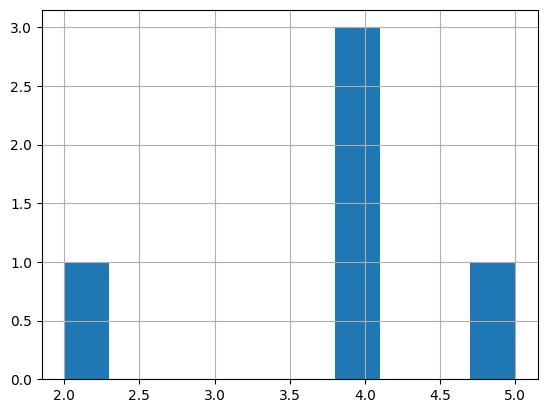

In [108]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]
pd.Series(seq_len).hist(bins = 10)
# Based on the histogram we are selecting the max len as 8
max_seq_len = 8

In [109]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

c:\Users\Apprenant\anaconda3\envs\deep-learning\Lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [110]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [111]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 16
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# DataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

In [112]:
class CAMEMBERT_Arch(nn.Module):
   def __init__(self, camembert):      
       super(CAMEMBERT_Arch, self).__init__()
       self.camembert = camembert 
      
       # dropout layer
       self.dropout = nn.Dropout(0.2)
      
       # relu activation function
       self.relu =  nn.ReLU()
       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,5)
       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)
       #define the forward pass
   def forward(self, sent_id, mask):
      #pass the inputs to the model  
      cls_hs = self.camembert(sent_id, attention_mask=mask)[0][:,0]
      
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      
      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)
      # output layer
      x = self.fc3(x)
   
      # apply softmax activation
      x = self.softmax(x)
      return x

In [113]:
# freeze all the parameters. This will prevent updating of model weights during fine-tuning.
for param in camembert.parameters():
      param.requires_grad = False
      
model = CAMEMBERT_Arch(camembert)
# push the model to GPU
model = model.to(device)

from torchinfo import summary
summary(model)

Layer (type:depth-idx)                                       Param #
CAMEMBERT_Arch                                               --
├─CamembertModel: 1-1                                        --
│    └─CamembertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                                   (24,579,840)
│    │    └─Embedding: 3-2                                   (394,752)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─CamembertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─CamembertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

In [114]:
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

from sklearn.utils.class_weight import compute_class_weight
# compute the class weights
class_wts = compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)
print(class_wts)

[1. 1. 1. 1. 1.]


c:\Users\Apprenant\anaconda3\envs\deep-learning\Lib\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [115]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy = nn.NLLLoss(weight=weights) 

In [116]:
from torch.optim import lr_scheduler
# empty lists to store training and validation loss of each epoch
train_losses=[]
# number of training epochs
epochs = 30
# We can also use learning rate scheduler to achieve better results
lr_sch = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

In [122]:
# function to train the model
def train():
  
  model.train()
  total_loss = 0
  
  # empty list to save model predictions
  total_preds=[]
  
  # iterate over batches
  for step, batch in enumerate(train_dataloader):
    
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step,    len(train_dataloader)))
      
    # push the batch to gpu
    batch = [r.to(device) for r in batch] 
    sent_id, mask, labels = batch
    # get model predictions for the current batch
    preds = model(sent_id, mask)
    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)
  
    writer.add_scalar("Loss/train", loss, step)
    
    # add on to the total loss
    total_loss = total_loss + loss.item()
    # backward pass to calculate the gradients
    loss.backward()
    # clip the the gradients to 1.0. It helps in preventing the    exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    # update parameters
    optimizer.step()
    # clear calculated gradients
    optimizer.zero_grad()
  
    # We are not using learning rate scheduler as of now
    # lr_sch.step()
    # model predictions are stored on GPU. So, push it to CPU
    preds = preds.detach().cpu().numpy()
    # append the model predictions
    total_preds.append(preds)
    
  # compute the training loss of the epoch
  avg_loss = total_loss / len(train_dataloader)
  writer.flush()
  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)
  #returns the loss and predictions
  return avg_loss, total_preds

In [123]:
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    # append training and validation loss
    train_losses.append(train_loss)
    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    

print(f'\nTraining Loss: {train_loss:.3f}')


 Epoch 1 / 30

 Epoch 2 / 30

 Epoch 3 / 30

 Epoch 4 / 30

 Epoch 5 / 30

 Epoch 6 / 30

 Epoch 7 / 30

 Epoch 8 / 30

 Epoch 9 / 30

 Epoch 10 / 30

 Epoch 11 / 30

 Epoch 12 / 30

 Epoch 13 / 30

 Epoch 14 / 30

 Epoch 15 / 30

 Epoch 16 / 30

 Epoch 17 / 30

 Epoch 18 / 30

 Epoch 19 / 30

 Epoch 20 / 30

 Epoch 21 / 30

 Epoch 22 / 30

 Epoch 23 / 30

 Epoch 24 / 30

 Epoch 25 / 30

 Epoch 26 / 30

 Epoch 27 / 30

 Epoch 28 / 30

 Epoch 29 / 30

 Epoch 30 / 30

Training Loss: 0.132


In [124]:
def get_prediction(str):
 str = re.sub(r'[^a-zA-Z ]+', '', str)
 test_text = [str]
 model.eval()
 
 tokens_test_data = tokenizer(
 test_text,
 max_length = max_seq_len,
 pad_to_max_length=True,
 truncation=True,
 return_token_type_ids=False
 )
 test_seq = torch.tensor(tokens_test_data['input_ids'])
 test_mask = torch.tensor(tokens_test_data['attention_mask'])
 
 preds = None
 with torch.no_grad():
   preds = model(test_seq.to(device), test_mask.to(device))
 preds = preds.detach().cpu().numpy()
 preds = np.argmax(preds, axis = 1)
 print("Intent Identified: ", le.inverse_transform(preds)[0])
 return le.inverse_transform(preds)[0]
def get_response(message): 
  intent = get_prediction(message)
  for i in data['intents']: 
    if i["tag"] == intent:
      result = random.choice(i["responses"])
      break
  print(f"Response : {result}")
  return "Intent: "+ intent + '\n' + "Response: " + result

In [125]:
get_response("Comment tu t'appelles ?")

Intent Identified:  name
Response : Mon nom est Florian


c:\Users\Apprenant\anaconda3\envs\deep-learning\Lib\site-packages\transformers\tokenization_utils_base.py:2346: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


'Intent: name\nResponse: Mon nom est Florian'